# Predicting Occupancy Rate

In [1]:
import pandas as pd 
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
fact_aggregated_bookings_df = pd.read_csv("fact_aggregated_bookings.csv")
dim_rooms_df = pd.read_csv("dim_rooms.csv")
dim_hotels_df = pd.read_csv("dim_hotels.csv")
dim_date_df = pd.read_csv("dim_date.csv")

In [4]:
df = pd.merge(fact_aggregated_bookings_df,  dim_rooms_df, left_on="room_category", right_on="room_id", how="left")
df = pd.merge(df, dim_hotels_df, on="property_id", how="left")
df = pd.merge(df, dim_date_df, left_on="check_in_date", right_on="date", how="left")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9200 entries, 0 to 9199
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   property_id          9200 non-null   int64 
 1   check_in_date        9200 non-null   object
 2   room_category        9200 non-null   object
 3   successful_bookings  9200 non-null   int64 
 4   capacity             9200 non-null   int64 
 5   room_id              9200 non-null   object
 6   room_class           9200 non-null   object
 7   property_name        9200 non-null   object
 8   category             9200 non-null   object
 9   city                 9200 non-null   object
 10  date                 9200 non-null   object
 11  mmm yy               9200 non-null   object
 12  week no              9200 non-null   object
 13  day_type             9200 non-null   object
dtypes: int64(3), object(11)
memory usage: 1006.4+ KB


### calculating occupancy rate

In [6]:
df['occupancy_rate'] = df['successful_bookings'] / df['capacity']

In [7]:
df['occupancy_rate']

0       0.833333
1       0.933333
2       0.766667
3       0.684211
4       0.947368
          ...   
9195    0.722222
9196    0.722222
9197    0.500000
9198    0.500000
9199    0.750000
Name: occupancy_rate, Length: 9200, dtype: float64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9200 entries, 0 to 9199
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   property_id          9200 non-null   int64  
 1   check_in_date        9200 non-null   object 
 2   room_category        9200 non-null   object 
 3   successful_bookings  9200 non-null   int64  
 4   capacity             9200 non-null   int64  
 5   room_id              9200 non-null   object 
 6   room_class           9200 non-null   object 
 7   property_name        9200 non-null   object 
 8   category             9200 non-null   object 
 9   city                 9200 non-null   object 
 10  date                 9200 non-null   object 
 11  mmm yy               9200 non-null   object 
 12  week no              9200 non-null   object 
 13  day_type             9200 non-null   object 
 14  occupancy_rate       9200 non-null   float64
dtypes: float64(1), int64(3), object(11)
me

In [9]:
df.drop(columns=["property_id", "check_in_date", "mmm yy", "week no", "date", "room_id"], inplace=True)

In [10]:
features = ['day_type', 'capacity', 'successful_bookings', 'property_name', 'city', 'room_category']
target = 'occupancy_rate'

### encoding categorical column

In [11]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = ["room_category", "property_name", "city", "day_type"]
le = LabelEncoder()

for col in categorical_cols:
  df[col] = le.fit_transform(df[col])

In [12]:
X = df[features]
y = df[target]

### spliting to training and testing data

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Linear Regression

In [14]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [15]:
y_pred = lr_model.predict(X_test)

from sklearn.metrics import r2_score

score = r2_score(y_test, y_pred)
print(f'r2 Score {score}')

r2 Score 0.8388004042708322


### Feature Importance graph for extracting features from datset to make prediction on target column

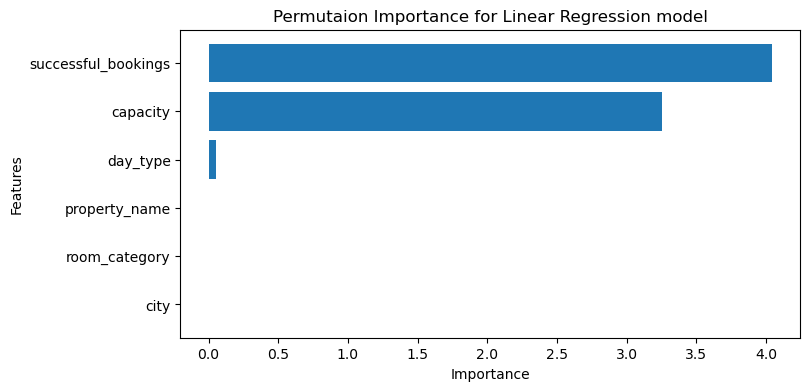

In [16]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(lr_model, X_test, y_test, scoring="r2")
importance_df = pd.DataFrame({
  'Feature' : X.columns,
  'Importance' : perm_importance.importances_mean
}).sort_values(by='Importance', ascending=True)

import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Permutaion Importance for Linear Regression model')
plt.show()

### Random forest Regressor

In [17]:
from sklearn.ensemble import RandomForestRegressor
rfreg_model = RandomForestRegressor(criterion='squared_error', max_depth=27, max_features='sqrt', min_samples_leaf=3, min_samples_split=3, n_estimators=106)
rfreg_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=27, max_features='sqrt', min_samples_leaf=3,
                      min_samples_split=3, n_estimators=106)

In [18]:
y_pred2 = rfreg_model.predict(X_test)

score2 = r2_score(y_test, y_pred2)
print(f'r2 Score {score2}')

r2 Score 0.9881423263794313


### Feature Importance graph for extracting features from datset to make prediction on target column

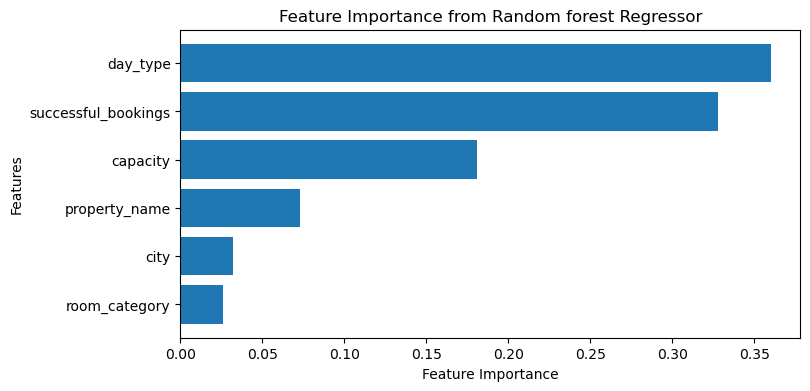

In [19]:
import matplotlib.pyplot as plt

feature_importances = rfreg_model.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance')

plt.figure(figsize=(8, 4))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance from Random forest Regressor')
plt.show()

### hyperparameter tuning using GridSearchCV to get the best parameters for model training

In [20]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for hyperparameter tuning
params = {
    'n_estimators': [67, 92, 106],          # Number of trees in the forest
    'max_depth': [8, 12, 27],               # Maximum depth of the trees
    'min_samples_split': [3, 5],            # Minimum number of samples required to split a node
    'min_samples_leaf': [3, 4],             # Minimum number of samples required in a leaf node
    'criterion': ['squared_error', 'absolute_error', 'poisson'],  # Loss function used for regression
    'max_features': ['sqrt', 'log2']        # Number of features considered for best split
}

# Initialize the RandomForestRegressor model
rf_regressor = RandomForestRegressor(random_state=42)

# Perform Grid Search with 5-fold cross-validation
grid = GridSearchCV(
    estimator=rf_regressor,  # Base model
    param_grid=params,       # Hyperparameter grid
    cv=5,                    # 5-fold cross-validation
    scoring='r2',            # Use R² score for evaluation (since it's a regression task)
    n_jobs=-1                # Use all available CPU cores for parallel processing
)

# Train the model using a subset of the dataset (X_train_sample, y_train_sample)
grid.fit(X_train, y_train)

# Print the best hyperparameters found by GridSearchCV
print("Best Parameters:", grid.best_params_)

# Get the best model with optimized hyperparameters
rf_model = grid.best_estimator_


Best Parameters: {'criterion': 'poisson', 'max_depth': 27, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 106}


### XGB Regressor

In [21]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimator=106, max_depth=27, criterion="poisson")
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, criterion='poisson', device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=27,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimator=106,
             n_estimators=None, n_jobs=None, ...)

In [22]:
y_pred3 = xgb_model.predict(X_test)

score3 = r2_score(y_test, y_pred3)
print(f'r2 Score {score3}')

r2 Score 0.999336226274039


### Feature Importance graph for extracting features from datset to make prediction on target column

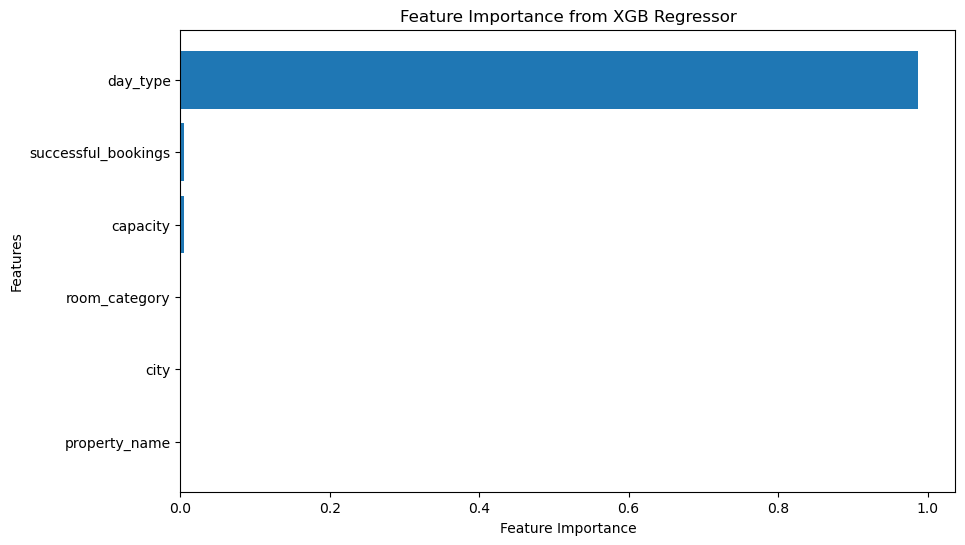

In [23]:
import matplotlib.pyplot as plt

feature_importances = xgb_model.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance')

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance from XGB Regressor')
plt.show()

### hyperparameter tuning using RandomizedSearchCV to get the best parameters for model training

In [24]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from xgboost import XGBRegressor

# Define hyperparameter search space
param_distributions = {
    'n_estimators': randint(200, 400),        # Number of trees
    'max_depth': randint(3, 15),              # Maximum depth of trees
    'learning_rate': uniform(0.01, 0.3),      # Learning rate
    'subsample': uniform(0.5, 0.5),           # Fraction of samples used for training each tree
    'colsample_bytree': uniform(0.5, 0.5),    # Fraction of features used per tree
    'gamma': uniform(0, 5),                   # Minimum loss reduction required for a split
    'min_child_weight': randint(1, 10),       # Minimum sum of instance weight needed in a child
    'reg_lambda': uniform(0, 5),              # L2 regularization
    'reg_alpha': uniform(0, 5)                # L1 regularization
}

# Initialize the XGBRegressor model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=21)

# Perform Randomized Search
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=20, 
    cv=5,
    scoring='r2',  # Use R² as the metric
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters:", random_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'colsample_bytree': 0.8238450602706812, 'gamma': 0.002601884976579094, 'learning_rate': 0.11577065690025069, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 397, 'reg_alpha': 2.553736512887829, 'reg_lambda': 2.087055015743895, 'subsample': 0.6110539052353652}


### function to predict Occupancy Rate based on features

In [25]:
def predict_occupancyRate(model, user_input):
  input_df = pd.DataFrame([user_input])

  categorical_cols = ["room_category", "property_name", "city", "day_type"]
  for col in categorical_cols:
    input_df[col] = le.fit_transform(input_df[col])

  occupancyRate_prediction = model.predict(input_df)
  return f'Prediction for Occupancy Rate: {occupancyRate_prediction[0]:.2f}'

In [26]:
user_input = {
  "day_type" : "weekday",
  "capacity" : 19, 
  "successful_bookings" : 18, 
  "property_name" : "Atliq Grands",
  "city" : "Delhi",
  "room_category" : "RT1"
}

In [27]:
print(predict_occupancyRate(rfreg_model, user_input))

Prediction for Occupancy Rate: 0.69
